In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, average_precision_score, precision_recall_curve
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score,roc_curve, auc
from sklearn.model_selection import GridSearchCV


In [2]:
## SepsisDataSet.csv
df = pd.read_csv('SepsisDataSet.csv')
df.shape

(1552210, 43)

In [3]:
df.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_id', 'time'],
      dtype='object')

In [4]:
lab=['BaseExcess','HCO3','FiO2','pH','PaCO2','SaO2','AST','BUN','Alkalinephos','Calcium','Chloride','Creatinine','Bilirubin_direct','Glucose','Lactate',
      'Magnesium','Phosphate','Potassium','Bilirubin_total','TroponinI','Hct','Hgb','PTT','WBC','Fibrinogen','Platelets']

vitals = ['DBP','EtCO2']

demo = ['Age','Gender','Unit1','Unit2','HospAdmTime','ICULOS', 'Patient_id', 'time']

label = ['SepsisLabel']

In [5]:
def drop_vitals(df):
    df.drop(vitals, axis = 1, inplace = True)
   
    
def drop_lab(df):
    df.drop(lab, axis = 1, inplace = True)

def drop_demo(df):
    df.drop(demo, axis = 1, inplace = True)

In [6]:
def carry_fwd_imp(df):
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

def drop_features(df):
    drop_vitals(df)
    drop_lab(df)
    drop_demo(df)
    

def drop_ado(df):
    df.drop(df[df.Age <= 15].index, inplace=True) 

In [7]:
drop_ado(df)
drop_features(df)
carry_fwd_imp(df)

In [8]:
df.head()

,HR,O2Sat,Temp,SBP,MAP,Resp,SepsisLabel
0,85.0,100.0,37.39,121.0,79.67,16.0,0
1,85.0,100.0,37.39,121.0,79.67,16.0,0
2,72.0,100.0,37.39,110.0,72.67,16.0,0
3,74.0,100.0,37.39,109.0,75.00,16.0,0
4,75.0,100.0,37.39,104.0,70.00,16.0,0


In [9]:
(df.isnull().sum().sort_values(ascending=False)/df.isnull().count()).sort_values(ascending=False)

Temp           0.0
SepsisLabel    0.0
SBP            0.0
Resp           0.0
O2Sat          0.0
MAP            0.0
HR             0.0
dtype: float64

In [10]:
def evaluation(clf, X, y):
    y_predict_proba = clf.predict_proba(X)[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y, y_predict_proba)
    fpr, tpr, thresholds = roc_curve(y, y_predict_proba)
    
    return auc(fpr, tpr), auc(recall, precision) 

In [11]:
y = df['SepsisLabel']
df.drop(['SepsisLabel'], axis = 1, inplace = True)
X_train, X_test, y_train, y_test = train_test_split( df , y , test_size=.2, random_state=40)


In [12]:
classifiers = [LogisticRegression(),
               GaussianNB(),
               DecisionTreeClassifier(),
               ## RandomForestClassifier(),
               AdaBoostClassifier(), 
               GradientBoostingClassifier()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss", "AUC", "AUPRC"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.2%}".format(acc))
    
    auc_train, auprc_train = evaluation(clf, X_train, y_train)
    print("Train:")
    print("ROC AUC: {:.6}".format(auc_train))
    print("PR AUC: {:.6}".format(auprc_train))
    print("Test:")
    auc_test, auprc_test = evaluation(clf, X_test, y_test)
    print("ROC AUC: {:.6}".format(auc_test))
    print("PR AUC: {:.6}".format(auprc_test))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll, auc_test, auprc_test]], columns=log_cols)
    log = log.append(log_entry)
    
    ##print("-"*30)
    ##print("Confusion Matrix")
    ##conf_matrix = confusion_matrix(y_test, train_predictions)
    ##sns.heatmap(conf_matrix, annot=True, fmt="d");
    
print("="*30)

LogisticRegression
****Results****
Accuracy: 98.23%
Train:
ROC AUC: 0.644595
PR AUC: 0.0370272
Test:
ROC AUC: 0.641348
PR AUC: 0.0360884
Log Loss: 0.08650935896993954
GaussianNB
****Results****
Accuracy: 97.53%
Train:
ROC AUC: 0.677831
PR AUC: 0.038583
Test:
ROC AUC: 0.67869
PR AUC: 0.0374769
Log Loss: 0.126802527005311
DecisionTreeClassifier
****Results****
Accuracy: 96.40%
Train:
ROC AUC: 0.999926
PR AUC: 0.996174
Test:
ROC AUC: 0.564681
PR AUC: 0.121643
Log Loss: 1.229264001939232
AdaBoostClassifier
****Results****
Accuracy: 98.23%
Train:
ROC AUC: 0.686839
PR AUC: 0.0430223
Test:
ROC AUC: 0.684723
PR AUC: 0.0403651
Log Loss: 0.6533388985962665
GradientBoostingClassifier
****Results****
Accuracy: 98.23%
Train:
ROC AUC: 0.696747
PR AUC: 0.0543668
Test:
ROC AUC: 0.692795
PR AUC: 0.045855
Log Loss: 0.08439535362622481


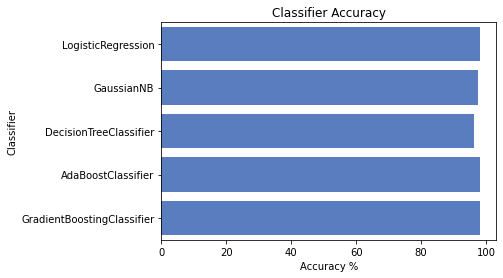

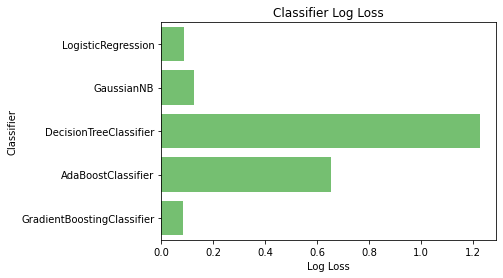

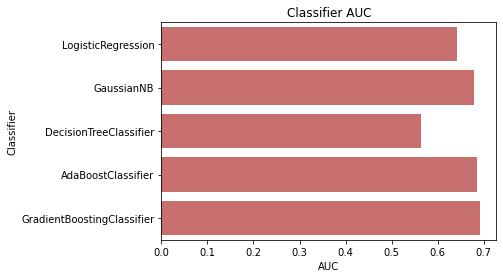

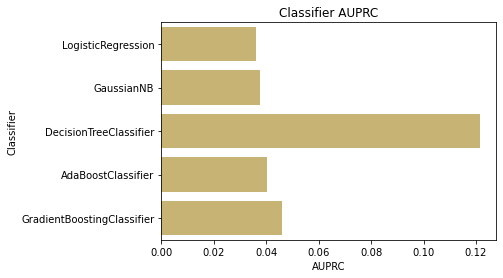

In [13]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='AUC', y='Classifier', data=log, color="r")

plt.xlabel('AUC')
plt.title('Classifier AUC')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='AUPRC', y='Classifier', data=log, color="y")

plt.xlabel('AUPRC')
plt.title('Classifier AUPRC')
plt.show()

In [17]:
classifiers = [RandomForestClassifier()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.2%}".format(acc))
    
    auc_train, auprc_train = evaluation(clf, X_train, y_train)
    print("Train:")
    print("ROC AUC: {:.6}".format(auc_train))
    print("PR AUC: {:.6}".format(auprc_train))
    print("Test:")
    auc_test, auprc_test = evaluation(clf, X_test, y_test)
    print("ROC AUC: {:.6}".format(auc_test))
    print("PR AUC: {:.6}".format(auprc_test))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll, auc_test, auprc_test]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

RandomForestClassifier
****Results****
Accuracy: 98.22%
Train:
ROC AUC: 0.999857
PR AUC: 0.987101
Test:
ROC AUC: 0.72255
PR AUC: 0.128385
Log Loss: 0.17637977140943842


ValueError: 3 columns passed, passed data had 5 columns

# Save Model as Pickle Object

In [15]:
import pickle

In [18]:
pickle.dump(clf, open('RF_Clf_model.pkl', 'wb'))

In [ ]:
##pickle.dump(clf, open('GB_Clf_model.pkl', 'wb'))

In [ ]:
classifiers = [RandomForestClassifier()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)